# Lagrangian Mechanics in Object Oriented Python

Consider a mass $m$ attached to a massless, inextensible string of length $l$ moving under the influence of the earth's gravitational field (i.e, the simple pendulum).

<img src="pendprob.png" alt="simple pend" width="300"/>

Using trigonometry, we see that the $x$ and $y$ coordinates of the pendulum's bob are given by: $x = l \sin \theta$, $y = -l \cos \theta $ 

The kinetic energy is thus given by $T = \frac 12 m \left( \dot x^2 + \dot y^2 \right)$ and the potential energy is $V = mgy$. Using this, we can construct the Lagrangian: $L(\theta, \dot \theta, t) = T-V$ and hence obtain the equations of motion using:

$$\frac{\partial L}{\partial \theta} = \frac d{dt} \frac{\partial L}{\partial \dot \theta}$$

These are all that we need to know to solve problems in Lagrangian mechanics in Python! 

In [1]:
#imports
import numpy as np 
import sympy as sp
from sympy.utilities import lambdify
from sympy.solvers import solve
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from matplotlib import animation
from matplotlib.animation import PillowWriter
from IPython.display import HTML
plt.style.use('seaborn')

In [2]:
class Pendulum:
    
    def __init__(self, l, t, theta0, v0):
        
        self.l = l
        self.t = t
        self.conds = [theta0, v0]
        
    def solvepend(self):
        
        m,g,l,t = sp.symbols(('m', 'g','l','t'))
        theta = sp.Function('theta')(t)
        dtheta = theta.diff(t)
        ddtheta = dtheta.diff(t)
        
        x,y = l*sp.sin(theta), -l*sp.cos(theta)
        
        T = sp.Rational(1,2) *m*(x.diff(t)**2+y.diff(t)**2)
        V = m*g*y
        L = T-V
        
        lhs = L.diff(theta)
        rhs = sp.diff( L.diff(dtheta), t)
        
        eq = rhs-lhs
        
        eq = sp.solve(eq, ddtheta)[0]
        
        dthetadt_num = sp.lambdify(dtheta, dtheta)
        dudt_num = sp.lambdify((g,l,theta), eq)
        
        x_num, y_num = sp.lambdify((l,theta), x), sp.lambdify((l,theta), y)
        
        del m,g,l,t
        
        g = 9.81
        l = self.l
        t = self.t
        conds = self.conds
        
        def dXdt(X,t,g,l):
            
            theta_num, u_num = X
            
            return [dthetadt_num(u_num),
                   dudt_num(g,l,theta_num)]
        
        sol = odeint(dXdt, t=t, y0 = conds, args= (g,l))
        angle = sol.T[0]
        velocity = sol.T[1]      
        
        return x_num(l,angle), y_num(l,angle)
            

In [9]:
t = np.linspace(0,10, 500)
pend = Pendulum(1,t,np.pi/4, 0)
x,y = pend.solvepend()

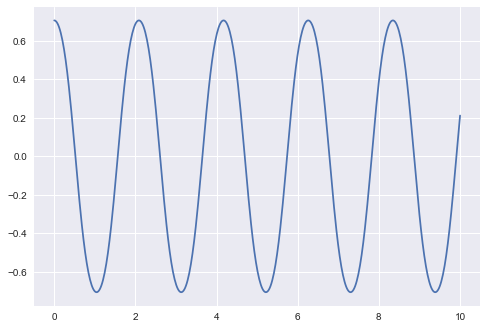

In [10]:
plt.plot(t,x)

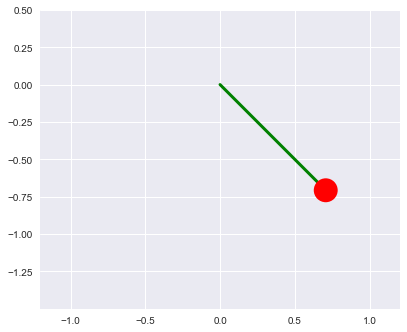

In [11]:
x0,y0 = x[0], y[0]

fig = plt.figure()
ax = fig.add_subplot(aspect='equal')

line, = ax.plot([0, x0], [0, y0], lw=3, c='green')
bob_radius = 0.08
circle = ax.add_patch(plt.Circle((x0,y0), bob_radius,
                      fc='r', zorder=3))

ax.set_xlim([-x.max()-0.5, x.max()+0.5])
ax.set_ylim([y.min()-0.5,0.5])

def animate(i):
    """Update the animation at frame i."""
    line.set_data([0, x[i]], [0, y[i]])
    circle.set_center((x[i], y[i]))

nsteps = len(x)
nframes = nsteps
dt = t[1]-t[0]
interval = dt * 1000
ani = animation.FuncAnimation(fig, animate, frames=nframes, repeat=True,
                              interval=interval)
HTML(ani.to_html5_video())

Credit for the animation code: https://scipython.com/book2/chapter-7-matplotlib/problems/p77/animating-a-pendulum/






$$\ddot \theta = -\frac gl \sin(\theta) $$

Let $u = \dot \theta$: $$\begin{cases} u= \dot \theta \\ \dot u = -\frac gl \sin \theta \end{cases}$$

Which can be written in vector/matrix form:

$$\begin{pmatrix} \dot \theta \\ \dot u \end{pmatrix}  = \begin{pmatrix} u \\ -\frac gl \sin \theta \end{pmatrix}$$

So we can define a state vector $X$ which we differentiate with respect to time to get the systems of equations for this system: $X :=(\theta, u)$ and 

$$\frac{dX}{dt} =  \begin{pmatrix} u \\ -\frac gl \sin \theta \end{pmatrix}$$

**To summarise**: 
* convert $\dot \theta$ and $\dot u$ into python functions that can be evaluated numerically. 
* create a function that takes in $\mathbf X$ and returns $\dot{\mathbf X}$. 
* call this function into ```scipy```'s ```odeint``` method to solve for $\theta$.